In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit,train_test_split,KFold
import lightgbm as lgb
from xgboost import XGBRegressor
from rfpimp import *
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt
import numpy as np
pd.set_option('max.rows',1000)
from pyearth import Earth
import statsmodels as sm
from collections import defaultdict
from tqdm import tqdm

/home/arya/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
train = pd.read_csv('Train.csv')
df_test = pd.read_csv('Test.csv')
df_sub = pd.read_excel('Sample_Submission.xlsx')

In [20]:
df = pd.concat([train,df_test])

In [3]:
train.describe()

,Day,GrocerySales
count,692.000000,692.000000
mean,346.500000,8564.733471
std,199.907479,428.815668
min,1.000000,6766.370000
25%,173.750000,8411.536858
50%,346.500000,8677.770000
75%,519.250000,8852.387500
max,692.000000,9290.020000


In [4]:
train.head()

,Day,GrocerySales
0,1,8418.59
1,2,8447.47
2,3,8336.49
3,4,8579.17
4,5,8524.31


Data is Quite less for a regression problem, also seems like we only have unique features thats a problem

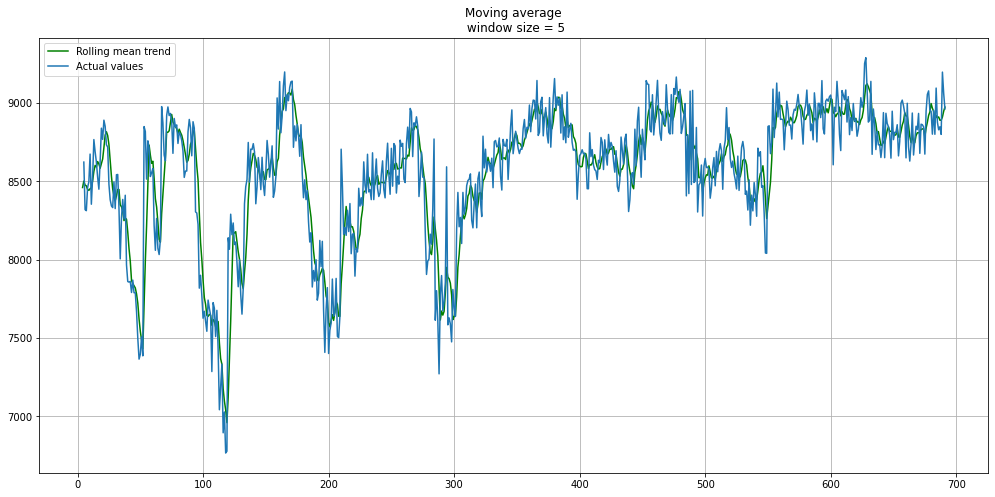

In [5]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 5 days (by week)
plot_moving_average(train.GrocerySales, 5)

# plot_moving_average(train.GrocerySales, 12)

# plot_moving_average(df.GrocerySales, 15)
# #Smooth by the previous month (30 days)
# plot_moving_average(df.GrocerySales, 30)

# #Smooth by previous quarter (90 days)
# plot_moving_average(df.GrocerySales, 90, plot_intervals=True)

The plot shows the price is going constant in the later days, also we can see a peak probably at 75-90 days and the curve than flattens out seems like a quarter maybe?

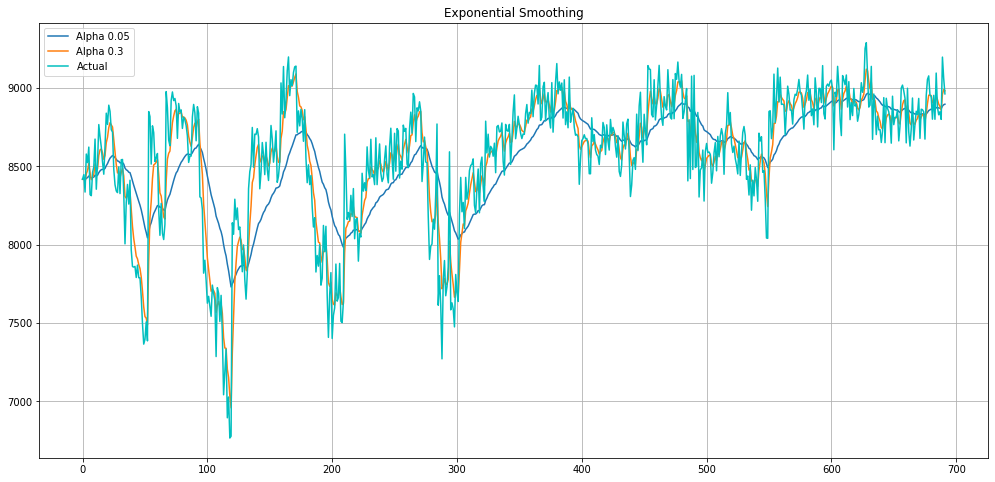

In [7]:
 def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(train.GrocerySales, [0.05, 0.3])

Smoothing the data could be helpful here could help a lot will use this to create features

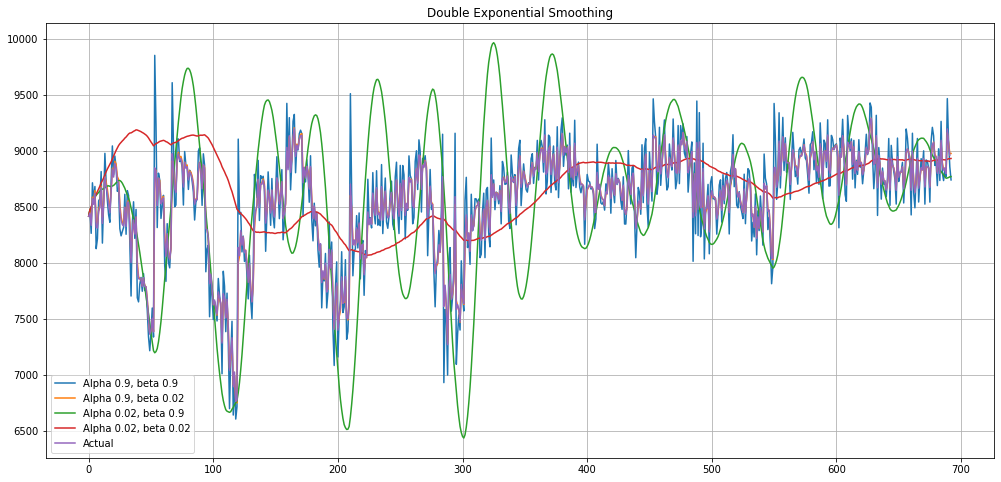

In [9]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    
plot_double_exponential_smoothing(train.GrocerySales, alphas=[0.9, 0.02], betas=[0.9, 0.02])

This isnt telling much but it seems the std deviation is reducing at the later days, (okay std of output should be a bit lesser than validation set),you see peaks are approx 75 to 90 days

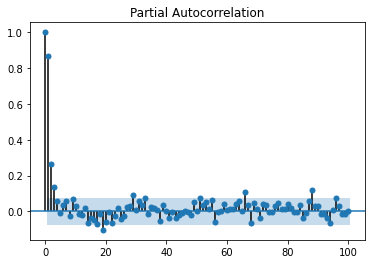

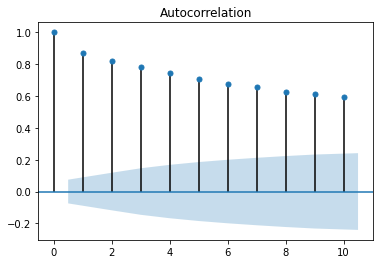

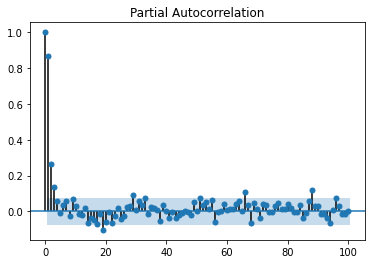

In [16]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(train['GrocerySales'], lags=10)
plot_pacf(train['GrocerySales'], lags=100)


We can see some points where there is statistical significance we can use these points, to create lag features, but first lets just assume that 90th day is probably a end of the quarter thats why the peak

In [18]:
def get_quarters(x):
    if x >= 0 and x <= 90 or x >= 361 and x <= 450 or x>=721 and x<=810:
        return 1
    elif x >= 91 and x <= 180 or x>=451 and x<=540:
        return 2
    elif x >= 181 and x <= 270 or x>=541 and x<=630:
        return 3
    else:
        return 4

In [21]:
df['Quarters'] = df['Day'].apply(lambda x: get_quarters(x))

In [22]:
def create_sales_rmean_feats(df, gpby_cols, target_col, windows, min_periods=2, 
                             shift=1, win_type=None):
    gpby = df.groupby(gpby_cols)
    for w in windows:
        df['_'.join([target_col, 'rmean', str(w)])] = \
            gpby[target_col].shift(shift).rolling(window=w, 
                                                  min_periods=min_periods,
                                                  win_type=win_type).mean().values +\
            np.random.normal(scale=1.6, size=(len(df),))
    return df

In [23]:
def create_sales_rmed_feats(df, gpby_cols, target_col, windows, min_periods=2, 
                            shift=1, win_type=None):
    gpby = df.groupby(gpby_cols)
    for w in windows:
        df['_'.join([target_col, 'rmed', str(w)])] = \
            gpby[target_col].shift(shift).rolling(window=w, 
                                                  min_periods=min_periods,
                                                  win_type=win_type).median().values +\
            np.random.normal(scale=1.6, size=(len(df),))
    return df

In [24]:
def create_sales_ewm_feats(df, gpby_cols, target_col, alpha=[0.9], shift=[1]):
    gpby = df.groupby(gpby_cols)
    for a in alpha:
        for s in shift:
            df['_'.join([target_col, 'lag', str(s), 'ewm', str(a)])] = \
                gpby[target_col].shift(s).ewm(alpha=a).mean().values
    return df

Lets create some features

In [25]:
create_sales_rmean_feats(df,gpby_cols='Quarters',target_col='GrocerySales',windows=[90,120,150,180])
create_sales_rmed_feats(df,gpby_cols='Quarters',target_col='GrocerySales',windows=[90,120,150,180])
create_sales_ewm_feats(df,gpby_cols='Quarters',target_col='GrocerySales',shift=[1,2,3,19,29,67],alpha=[0.9,0.95,0.85,0.80,0.7,0.6,0.5])

,Day,GrocerySales,Quarters,GrocerySales_rmean_90,GrocerySales_rmean_120,GrocerySales_rmean_150,GrocerySales_rmean_180,GrocerySales_rmed_90,GrocerySales_rmed_120,GrocerySales_rmed_150,...,GrocerySales_lag_3_ewm_0.6,GrocerySales_lag_19_ewm_0.6,GrocerySales_lag_29_ewm_0.6,GrocerySales_lag_67_ewm_0.6,GrocerySales_lag_1_ewm_0.5,GrocerySales_lag_2_ewm_0.5,GrocerySales_lag_3_ewm_0.5,GrocerySales_lag_19_ewm_0.5,GrocerySales_lag_29_ewm_0.5,GrocerySales_lag_67_ewm_0.5
0,1,8418.590000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,8447.470000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,8418.590000,NaN,NaN,NaN,NaN,NaN
2,3,8336.490000,1,8436.362463,8432.568815,8433.270663,8430.353406,8432.192860,8435.252484,8433.367725,...,NaN,NaN,NaN,NaN,8437.843333,8418.590000,NaN,NaN,NaN,NaN
3,4,8579.170000,1,8401.113558,8400.797148,8399.202312,8397.939223,8416.395438,8418.637300,8419.726180,...,8418.590000,NaN,NaN,NaN,8379.927143,8437.843333,8418.590000,NaN,NaN,NaN
4,5,8524.310000,1,8445.200326,8447.483547,8444.745354,8443.281703,8434.491830,8436.609494,8433.386656,...,8439.218571,NaN,NaN,NaN,8486.190000,8379.927143,8437.843333,NaN,NaN,NaN
5,6,8623.500000,1,8461.777636,8459.325992,8463.094707,8461.480541,8447.831697,8448.467041,8450.319947,...,8373.366923,NaN,NaN,NaN,8505.864839,8486.190000,8379.927143,NaN,NaN,NaN
6,7,8320.110000,1,8490.444311,8487.817442,8487.582240,8487.266436,8488.332709,8486.958700,8484.452695,...,8500.092956,NaN,NaN,NaN,8565.616032,8505.864839,8486.190000,NaN,NaN,NaN
7,8,8313.530000,1,8463.531635,8467.497190,8463.980765,8462.396210,8450.284932,8450.866165,8448.409898,...,8514.773511,NaN,NaN,NaN,8441.896457,8565.616032,8505.864839,NaN,NaN,NaN
8,9,8461.340000,1,8444.753917,8445.126212,8445.954067,8448.104891,8429.851526,8434.367239,8435.508920,...,8580.277710,NaN,NaN,NaN,8377.461529,8441.896457,8565.616032,NaN,NaN,NaN
9,10,8497.240000,1,8445.687647,8448.485656,8444.813718,8445.982663,8445.680832,8447.036192,8448.027533,...,8423.920909,NaN,NaN,NaN,8419.482838,8377.461529,8441.896457,NaN,NaN,NaN


In [26]:
X_test = df[df['Day'] >=693]
X_test.drop('GrocerySales',inplace=True,axis=1)

/home/arya/.local/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [27]:
X_train = df[df['Day'] < 693]
X_train.dropna(inplace=True)

/home/arya/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [28]:
X_valid=X_train[X_train['Day'] > 660]
y_valid = X_valid['GrocerySales']
X_valid = X_valid.drop('GrocerySales',axis=1)
X_train = X_train[X_train['Day'] <= 660]
y_train = X_train['GrocerySales']
X_train = X_train.drop('GrocerySales',axis=1)

Only creating a validation set that comprises of 30 days because the std drops massively before that and we dont really have enough data to capture that

In [29]:
m =lgb.LGBMRegressor(random_state=22,n_jobs=-1,max_depth=-1)
m.fit(X_train,y_train)
print(sqrt(mean_squared_error(y_true=m.predict(X_valid),y_pred=y_valid)))

147.85775285280374


Baseline seems nice 

In [31]:
m.predict(X_valid).std(),y_valid.std()

(74.31427644216863, 141.86506756727303)

Maybe Not 

OK I did some feature selection using feature importance and i got some good features

In [33]:
feats = ['GrocerySales_lag_1_ewm_0.9','GrocerySales_lag_1_ewm_0.6','GrocerySales_lag_1_ewm_0.95','GrocerySales_lag_1_ewm_0.5'
        ,'GrocerySales_lag_3_ewm_0.8','GrocerySales_lag_1_ewm_0.8','GrocerySales_lag_67_ewm_0.6','GrocerySales_lag_3_ewm_0.5'
        ,'GrocerySales_lag_2_ewm_0.7']

In [34]:
m =lgb.LGBMRegressor(random_state=22,n_jobs=-1,max_depth=-1)
m.fit(X_train[feats],y_train)
print(sqrt(mean_squared_error(y_true=m.predict(X_valid[feats]),y_pred=y_valid)))

167.96034303612308


In [36]:
m.predict(X_valid[feats]).std(),y_valid.std()

(106.49867349950473, 141.86506756727303)

This does seem better

So then i trained the model and fine tuned it using Grid search and time series split with 5 folds and got my score

In [38]:
cv = TimeSeriesSplit(n_splits=5)
results = pd.DataFrame(columns=['training_score', 'test_score'])
score_avg = []
for (train, test), i in zip(cv.split(X_train, y_train), range(5)):
    m = lgb.LGBMRegressor(random_state=22,n_jobs=-1,max_depth=-1)
    m.fit(X_train[feats].iloc[train], y_train.iloc[train])
    score_avg.append(sqrt(mean_squared_error(y_pred=m.predict(X_train[feats].iloc[test]),y_true=y_train.iloc[test])))
print(pd.DataFrame(data=score_avg))
print(sum(score_avg)/len(score_avg))

            0
0  357.906229
1  249.472493
2  144.489850
3  212.009133
4  165.031242
225.78178943322868


Also, you probably just need to fine tune the model using Gridsearch to get the final result

In [39]:
imp = importances(m,X_valid[feats],y_valid,n_samples=-1)

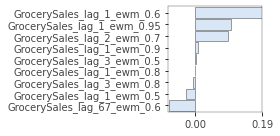

In [40]:
viz = plot_importances(imp)
viz.view()

Also Permutation Importance is the Truth

In [41]:
df_test['Quarters'] = df_test['Day'].apply(lambda x:get_quarters(x))

In [43]:
df_sub['GrocerySales'] = m.predict(X_test[feats])
df_sub.to_excel('With_Quarters.xlsx',index=False)

In [44]:
df_sub['GrocerySales'].std()

99.26918426005412

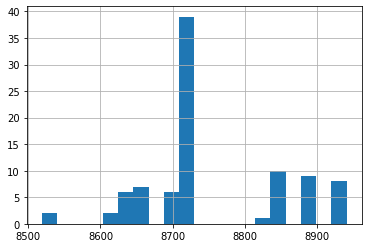

In [45]:
df_sub['GrocerySales'].hist(bins=20)

When you fine tune the model you will see a better standard deviation and a better histogram , probably prophet or a simple Multivariate Spline could have worked too 